# <span style="color:#ffe8d6"><b>Olist Data Cleaning Notebook</b></span>
## <span style="color:#e9c46a"><i>Quickly explore, tidy, and prep the Olist dataset for insightful analysis.</i></span>
# 
### <span style="color:#dda15e"><b>Steps:</b></span> <span style="color:#FFA500">Load data</span> • <span style="color:#bc6c25">Visualize nulls</span> • <span style="color:#20B2AA">Initial inspection</span> • <span style="color:#e9c46a">Prep for modeling</span>



In [122]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import app.assets.preprocessing as preprocessing

data = preprocessing.load_raw_data()



In [123]:
"""
Load data
"""

df_customer = data['customer']
df_order = data['order']
df_geo = data['geo']
df_order_item = data['order_item']
df_product = data['product']
df_order_payment = data['order_payment']
df_order_review = data['order_review']
df_seller = data['seller']
df_product_category = data['product_category']

In [124]:
"""
Check for nulls in each dataset
"""

nulls_geo = df_geo.loc[:,(df_geo.isna().sum() > 0).values]
nulls_orders = df_order.loc[:,(df_order.isna().sum() > 0).values]
nulls_order_item = df_order_item.loc[:,(df_order_item.isna().sum() > 0)]
nulls_order_payment = df_order_payment.loc[:,(df_order_payment.isna().sum() > 0)]
nulls_order_review = df_order_review.loc[:,(df_order_review.isna().sum() > 0)]
nulls_product = df_product.loc[:,(df_product.isna().sum() > 0)]
nulls_seller = df_seller.loc[:,(df_seller.isna().sum() > 0)]
nulls_product_category = df_product_category.loc[:,(df_product_category.isna().sum() > 0)]
nulls_customer = df_customer.loc[:,(df_customer.isna().sum() > 0)]

print("------Nulls?------")
print("Geolocation: ", nulls_geo.shape[1] > 1)
print("Orders: ",nulls_orders.shape[1] > 1)
print("Order Item: ",nulls_order_item.shape[1] > 1)
print("Order Payment: ",nulls_order_payment.shape[1] > 1)
print("Order Review: ",nulls_order_review.shape[1] > 1)
print("Product: ",nulls_product.shape[1] > 1)
print("Seller: ",nulls_seller.shape[1] > 1)
print("Product Category: ",nulls_product_category.shape[1] > 1)
print("Customer: ",nulls_customer.shape[1] > 1)

------Nulls?------
Geolocation:  False
Orders:  True
Order Item:  False
Order Payment:  False
Order Review:  True
Product:  True
Seller:  False
Product Category:  False
Customer:  False


> **Observations:** Nulls found in Orders, Order Review, and Product datasets. 

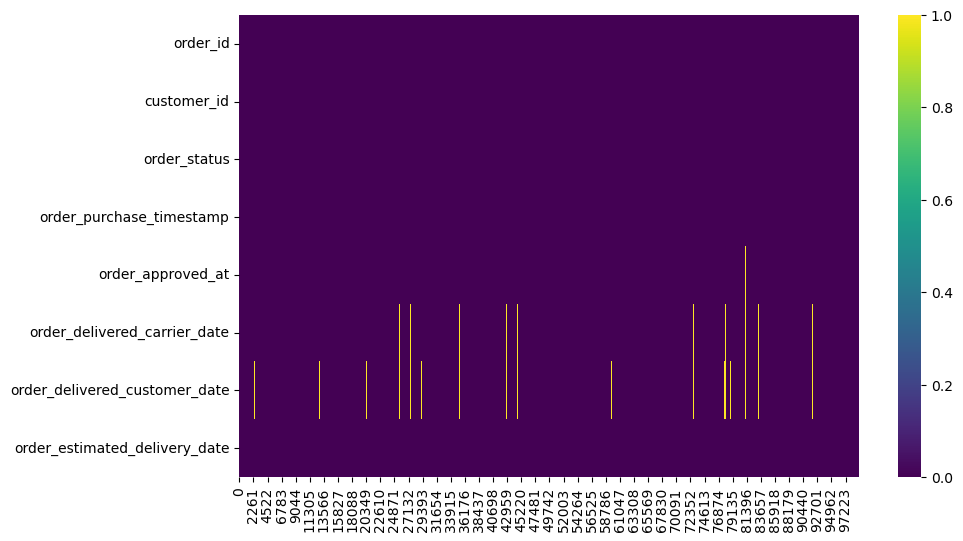

In [127]:
# Show missing values

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_order.isna().transpose(), cmap='viridis', ax=ax)
plt.show()

> **Observation:** Missing values cluster around 'order_delivered_customer_date' and 'order_delivered_carrier_date', with some in 'order_approved_at'
>
> **Hypothesis:** Missing values are do to cancellations.
>
> **Next Steps:** Check if there is missing values are found in records with cancelled order status

In [78]:
# Calculate pct of records with missing values and cancelled order status vs pct of records with missing values and not cancelled status

# Whenever customer delivery date is missing, carrier delivery date is missing as well
missing_mask = df_order['order_delivered_customer_date'].isna()
delivered = df_order['order_status'] == 'delivered'
missing_delivery_delivered = len(df_order.loc[missing_mask & delivered])
missing_delivery_not_delivered = len(df_order.loc[missing_mask & ~delivered])
total_orders = len(df_order)

print("Missing delivery values with delivered status:",f'{missing_delivery_delivered / total_orders * 100:.2f}%')
print("Missing delivery values without delivered status",f'{missing_delivery_not_delivered / total_orders * 100:.2f}%')



Missing delivery values with delivered status: 0.01%
Missing delivery values without delivered status 2.97%


> **Takeaways:** Only 0.01% of missing values occur in records with 'delivered' status. These are likely due to random error.
>
> **Next Steps:** Determine which delivery status is responsible for the majority of the 2.97% of nulls. 

In [79]:
# All order statuses
df_order["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [80]:
# Query for all statuses other than 'delivered'

not_delivered = (df_order.loc[missing_mask & ~ delivered]
                .groupby('order_status')['order_id']
                .count()
                .reset_index()
                .sort_values(by='order_id', ascending=False))

chart = alt.Chart(not_delivered).mark_bar().encode(
    x=alt.X('order_status:N', title='Order Status', sort='-y'),
    y=alt.Y('order_id:Q', title='Count')
).properties(width=750, title='Count of Null Delivery Dates by Order Status')

chart

alt.Chart(...)

> **Observations:** Majority of missing nulls are due to legitamate reasons, such as shipping, cancelled, invoiced, etc... Some are unexplained with 'unavailable'. 
>
> **Next Steps:** Look into patterns with 'unavailable' order status

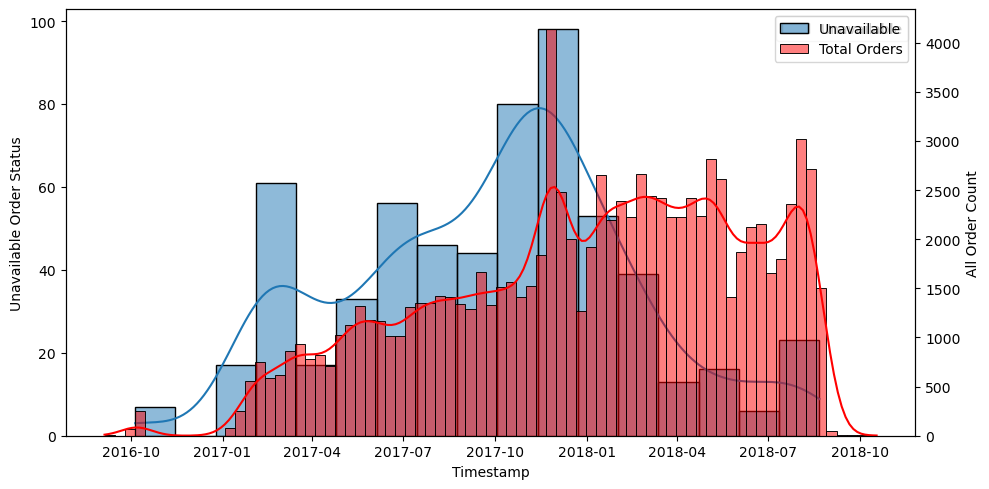

In [81]:
# Filter for only unavailable orders
mask = df_order['order_status'] == 'unavailable'
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])

# Unavailable histogram
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.histplot(df_order.loc[mask], x=df_order.loc[mask, 'order_purchase_timestamp'], ax=ax1, label='Unavailable', kde=True)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Unavailable Order Status')
ax1.legend()

# Total orders histogram
ax2 = ax1.twinx()
sns.histplot(df_order, x='order_purchase_timestamp', ax=ax2, kde=True, color="red", label='Total Orders')
ax2.set_xlabel("All orders")
ax2.set_ylabel("All Order Count")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()




> **Observation:** Unavailable order status' follow a similar trend as total orders, indicating that this is due to normal software or human error. 
> 
> **Next Steps:** Impute missing values with 'unavailable' order status.

In [ ]:
"""
Impute missing values with 'unavailable' order status by grouping by seller zip code prefix and getting
median values for customer and carrier delivery dates.
"""
# Filter for only unavailable and delivered orders
mask = df_order['order_status'].isin(['unavailable', 'delivered'])

df_order['order_delivered_customer_date'] = pd.to_datetime(df_order['order_delivered_customer_date'])
df_order['order_delivered_carrier_date'] = pd.to_datetime(df_order['order_delivered_carrier_date'])

# List of columns to pull after grouping
group_cols = ['seller_zip_code_prefix', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_status']

# Merge with order_item and seller datasets
filled = (
    df_order[mask] # Only unavailable and delivered orders
    .merge(df_order_item[['seller_id','order_id']], how='left') # Merge for seller_id
    .merge(df_seller[['seller_id','seller_zip_code_prefix']], how='left') # Merge for zip code

    # Group to get median values per zip code
    .groupby('seller_zip_code_prefix')[group_cols]
    .apply(
        lambda g: g.assign(
        # Fill customer delivery date with values from records with order_status as delivered
            order_delivered_customer_date=g['order_delivered_customer_date'].fillna(
                g.loc[g['order_status'] == 'delivered', 'order_delivered_customer_date'].median()
            ),
        # Fill carrier delivery date with values from records with order_status as delivered
            order_delivered_carrier_date=g['order_delivered_carrier_date'].fillna(
                g.loc[g['order_status'] == 'delivered', 'order_delivered_carrier_date'].median()
            )
        )
    )
    .reset_index(drop=True)
)

In [103]:
order_status_mask = df_order['order_status'] == 'unavailable'
filled_mask = filled['order_status'] == 'unavailable'

print("Unavailable orders in original df_orders:", order_status_mask.sum())
print("Unavailable orders in filled df:", filled_mask.sum())
print()


Unavailable orders in original df_orders: 609
Unavailable orders in filled df: 7



> **Observation:** Unavailable orders are getting excluded in groupby 
> #
> **Next Steps:** Examine where unavailable orders are getting lost 

In [110]:
mask = df_order['order_status'].isin(['unavailable', 'delivered']) # Filter for only unavailable and delivered orders

merge_1 = df_order[mask].merge(df_order_item[['seller_id','order_id']], how='left') # Merge for seller_id
merge_2 = merge_1.merge(df_seller[['seller_id','seller_zip_code_prefix']], how='left') # Merge for zip code

mask1 = (merge_2['order_status'] =='unavailable') # Filter for unavailable orders
mask2 = (merge_2['seller_zip_code_prefix'].isna()) # Filter for records with no zip code
mask3 = mask1 & mask2 # Filter for unavailable orders with no zip code
print("Unavailable orders with no zip code:", mask3.sum())
print("Unavailable orders with zip code:", mask1.sum() - mask3.sum())
print("Percentage of unavailable orders with no zip code: %", round(mask3.sum() / mask1.sum() * 100, 2))


Unavailable orders with no zip code: 603
Unavailable orders with zip code: 7
Percentage of unavailable orders with no zip code: % 98.85


> **Observation:** Vast majority of orders with unavailable order status have no seller zip code **(%98.85)**
> #
> **Hypothesis:** These orders may have been cancelled before seller ever received order confirmation. In this scenario, Olist never got confirmation from the seller that the order was cancelled.
> # 
> **Next Steps: Proceed with imputation to discover more about cancellation behavior** 

In [112]:
# Verify imputation

print("Nulls before in customer date:", df_order['order_delivered_customer_date'].isna().sum())
print("Nulls before in carrier date:", df_order['order_delivered_carrier_date'].isna().sum())
df_order['order_delivered_customer_date'] = filled['order_delivered_customer_date']
df_order['order_delivered_carrier_date'] = filled['order_delivered_carrier_date']
print("Nulls after in customer date:", df_order['order_delivered_customer_date'].isna().sum())
print("Nulls after in carrier date:", df_order['order_delivered_carrier_date'].isna().sum())

Nulls before in customer date: 2965
Nulls before in carrier date: 1783
Nulls after in customer date: 2
Nulls after in carrier date: 2


In [ ]:
test_mask1 = df_order['order_status'] == "unavailable"
test_mask2 = df_order['order_delivered_customer_date'].isna()
test_mask3 = df_order['order_delivered_carrier_date'].isna()
test_mask4 = test_mask1 & test_mask2
test_mask5 = test_mask1 & test_mask3
print("Unavailable orders with no customer delivery date:", test_mask4.sum())
print("Unavailable orders with no carrier delivery date:", test_mask5.sum())

Unavailable orders with no customer delivery date: 0
Unavailable orders with no carrier delivery date: 0


In [118]:
test_mask6 = df_order['order_delivered_customer_date'].isna()
test_mask7 = df_order['order_delivered_carrier_date'].isna()
test_mask8 = test_mask6 | test_mask7
print("Records with no customer or carrier delivery date:", test_mask8.sum())

Records with no customer or carrier delivery date: 2


In [119]:
df_order[test_mask8]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
83112,74b718d85b8c1c2071fb5f4e7c7a1114,23439db933ef777c7a62cc7355cfe933,delivered,2018-01-30 21:08:20,2018-01-30 21:31:28,NaT,NaT,2018-03-02 00:00:00
93219,e38ed8e03fde2a21027ba6a431e9808c,d5c08d6e9c2263955bde6c3178e46123,delivered,2017-12-22 09:41:26,2017-12-22 09:50:26,NaT,NaT,2018-01-23 00:00:00


In [20]:
def add_customer_spending(data: dict) -> dict:
    """
    Add the customer spending feature to the customer dataset. 
    Ranks customer 0,1,2 quartiles of total spending.
    """
    data['customer'] = data['customer']
    data['order'] = data['order']
    data['order_payment'] = data['order_payment']

    merged = pd.merge(data['customer'], data['order'], on='customer_id', how='inner')
    merged = pd.merge(merged, data['order_payment'], on='order_id', how='inner')
    customer_spending = merged.groupby('customer_id')['payment_value'].sum().to_frame()

    # Discretize spending
    kbd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

    # Fit and transform
    kbd.fit(customer_spending)
    customer_spending['customer_spending'] = kbd.transform(customer_spending)

    # Merge with customer dataset
    data['customer'] = pd.merge(data['customer'], customer_spending, on='customer_id', how='inner')
    return data


data = add_customer_spending(data)


In [21]:
# Check customer spending
data['customer'].head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,customer_spending
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,146.87,1.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,335.48,2.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,157.73,2.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,173.30,2.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,252.25,2.0
